In [1]:
# General
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (16,7)
mpl.rcParams["image.interpolation"] = "nearest"
mpl.rcParams["image.origin"] = "lower"
import pysynphot as S
from astropy.table import Table
import webbpsf
import scipy

# Grizli
import grizli
from grizli.model import GrismFLT

from astropy.modeling.functional_models import Gaussian2D as gauss

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/6) predictable_extract/fits/")

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
empty_dir = "empty_direct.fits"
empty_seg = "empty_seg.fits"
pad = 100
roman = GrismFLT(direct_file=empty_dir, seg_file=empty_seg, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [3]:
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Read in star spectrum
src = webbpsf.specFromSpectralType('G0V', catalog='phoenix')
wave = np.linspace(10000,20000,10000) # Angstroms
flux = src(wave).value
star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="photlam")
star_spec = star_spec.renorm(1, "abmag", bp)
star_spec.convert("flam")

# read in sensitivity file
sens = Table.read("/Users/keith/astr/research_astr/summer-roman-project/toy_configs/sens_0720_2020.fits", format="fits")
interpolated_sens = np.interp(wave, sens["WAVELENGTH"], sens["SENSITIVITY"])

# Single Pixel
# Single Pixel
# Single Pixel

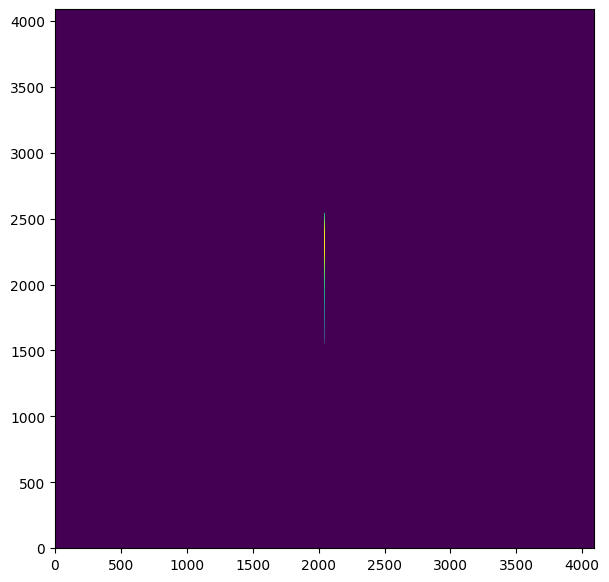

In [4]:
dir = np.zeros((4288,4288), dtype="float32") # pad=100
dir[2144, 2144] = 1.

roman.direct.data["SCI"] = roman.seg = dir

model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=5,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

upright = np.rot90(model[pad:-pad, pad:-pad])
plt.imshow(upright)

In [5]:
# Demonstrating our cutout dimensions are correct
upright[2044 - 502: 2044+501, 2043:2046]

array([[       0. ,        0. ,        0. ],
       [       0. ,  1855755.6,        0. ],
       [       0. ,  1984429.1,        0. ],
       ...,
       [       0. , 27812042. ,        0. ],
       [       0. , 27752116. ,        0. ],
       [       0. ,        0. ,        0. ]], dtype=float32)

In [6]:
cutout = np.flip(upright[2044-501: 2044+500, 2044]) # proper limits are y=[-500:500], x=[2144]
pix = np.linspace(2044-501, 2044+500, len(cutout))

expected_values = star_spec.flux * interpolated_sens
binned_expectation = scipy.stats.binned_statistic(star_spec.wave, expected_values, statistic="sum", bins=1001)[0]
wave = np.linspace(10000, 20000, len(cutout))

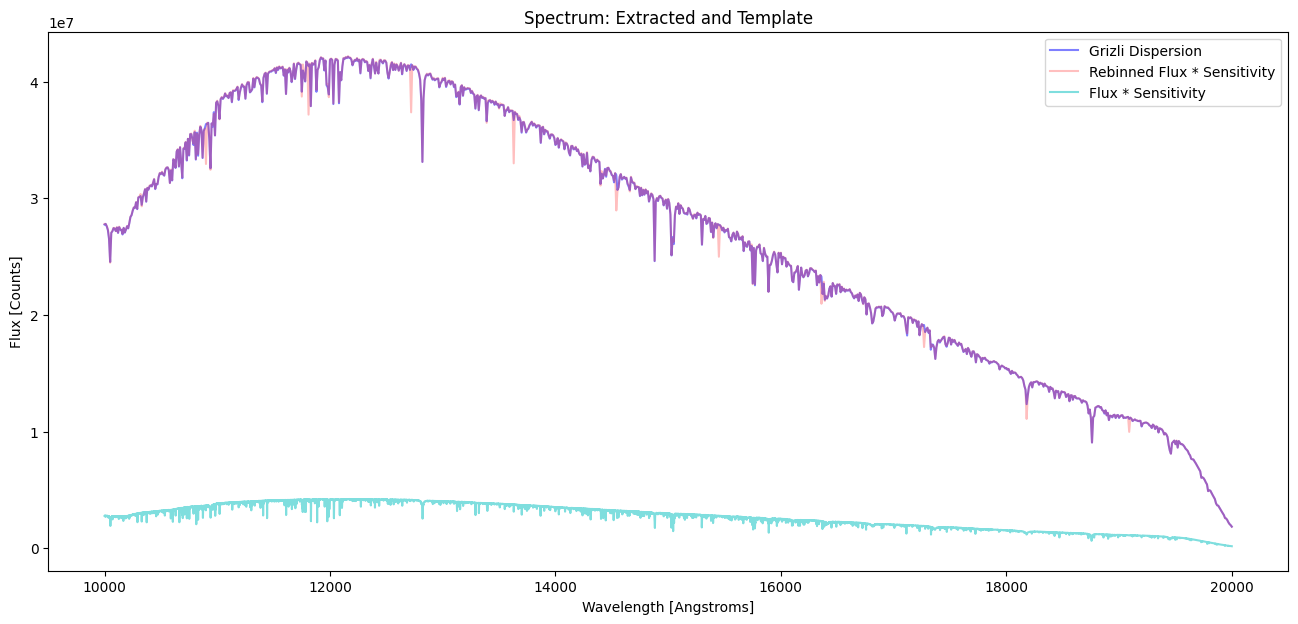

In [7]:
plt.plot(wave, cutout, c='b', alpha=0.5, label="Grizli Dispersion")
plt.plot(wave, binned_expectation, c='r', alpha=0.25, label="Rebinned Flux * Sensitivity")
plt.plot(star_spec.wave, expected_values, c='c', alpha=0.5, label="Flux * Sensitivity")

plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [Counts]")
plt.title("Spectrum: Extracted and Template")
plt.legend()

# Line Orthogonal to Dispersion Trace
# Line Orthogonal to Dispersion Trace
# Line Orthogonal to Dispersion Trace

Text(0.5, 1.0, 'Segmentation Map')

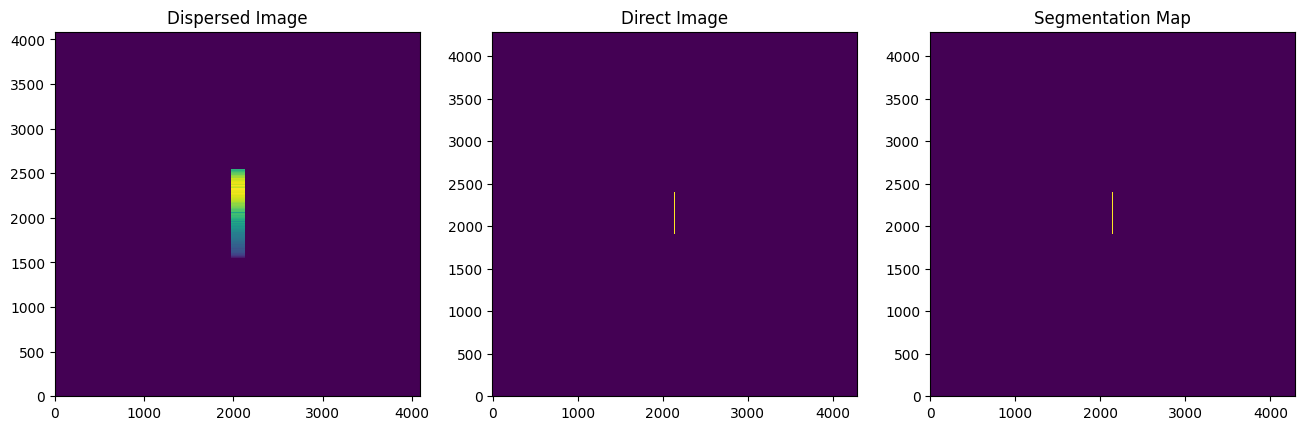

In [8]:
dir = np.zeros((4288,4288), dtype="float32")

dir[1900:2400, 2144] = 1.

roman.direct.data["SCI"] = roman.seg = dir

model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

upright = np.rot90(model[pad:-pad, pad:-pad])

ax1.imshow(upright)
ax1.set_title("Dispersed Image")

ax2.imshow(roman.direct.data["SCI"])
ax2.set_title("Direct Image")

ax3.imshow(roman.seg)
ax3.set_title("Segmentation Map")

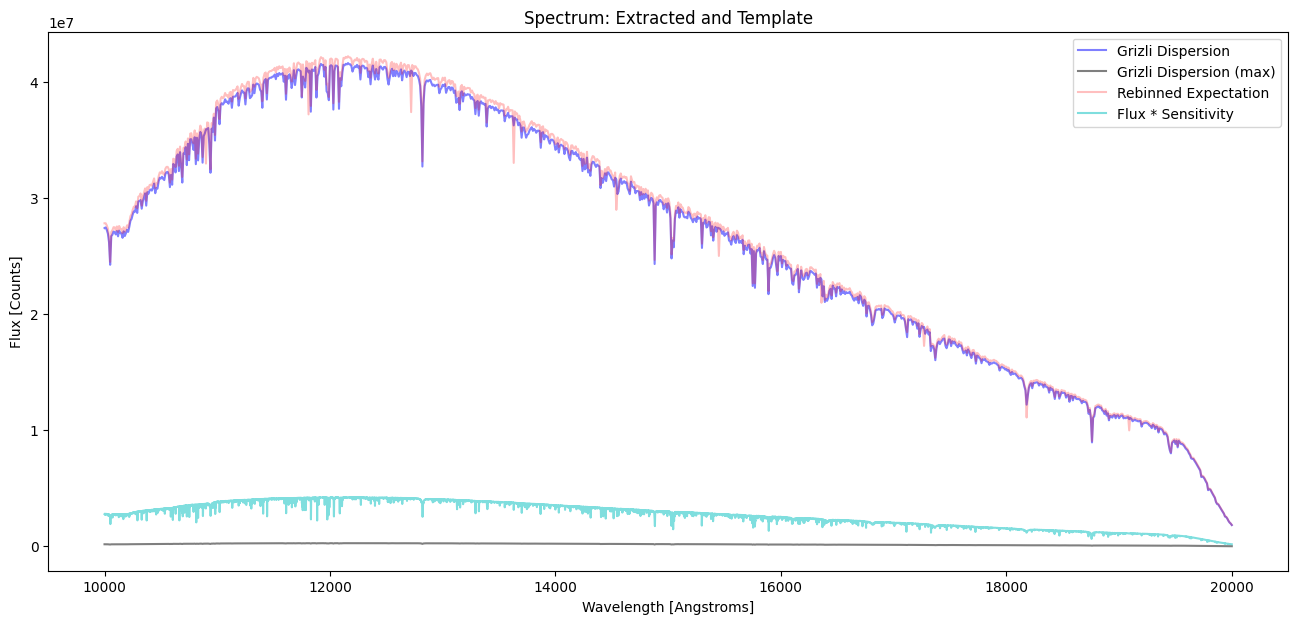

In [9]:
cutout = np.flip(upright[2044-501: 2044+500, :])

counts = []
count_max = []
for ii in range(cutout.shape[0]):
    counts.append(cutout[ii,:].sum())
    count_max.append(cutout[ii,:].max())

expected_values = star_spec.flux * interpolated_sens
binned_expectation = scipy.stats.binned_statistic(star_spec.wave, expected_values, statistic="sum", bins=1001)[0]
wave = np.linspace(10000, 20000, len(cutout))

plt.plot(wave, counts, c='b', alpha=0.5, label="Grizli Dispersion")
plt.plot(wave, count_max, c='k', alpha=0.5, label="Grizli Dispersion (max)")
plt.plot(wave, binned_expectation, c='r', alpha=0.25, label="Rebinned Expectation")
plt.plot(star_spec.wave, expected_values, c='c', alpha=0.5, label="Flux * Sensitivity")

plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [Counts]")
plt.title("Spectrum: Extracted and Template")
plt.legend()

# Line Parallel to Trace
# Line Parallel to Trace
# Line Parallel to Trace

Text(0.5, 1.0, 'Segmentation Map')

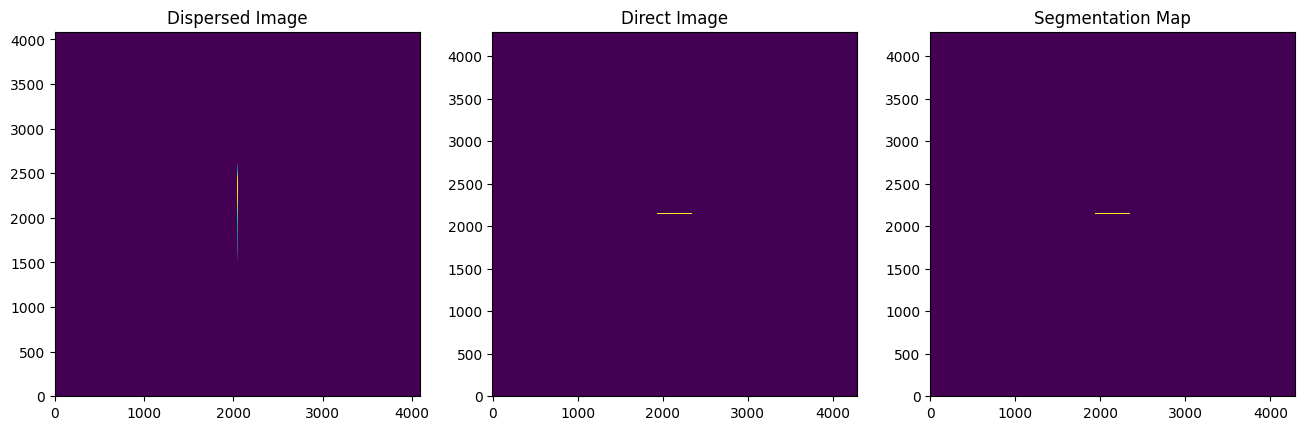

In [10]:
dir = np.zeros((4288,4288), dtype="float32")

dir[2144, 2144-200:2144+200] = 1.

roman.direct.data["SCI"] = roman.seg = dir

model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

upright = np.rot90(model[pad:-pad, pad:-pad])

ax1.imshow(upright)
ax1.set_title("Dispersed Image")

ax2.imshow(roman.direct.data["SCI"])
ax2.set_title("Direct Image")

ax3.imshow(roman.seg)
ax3.set_title("Segmentation Map")

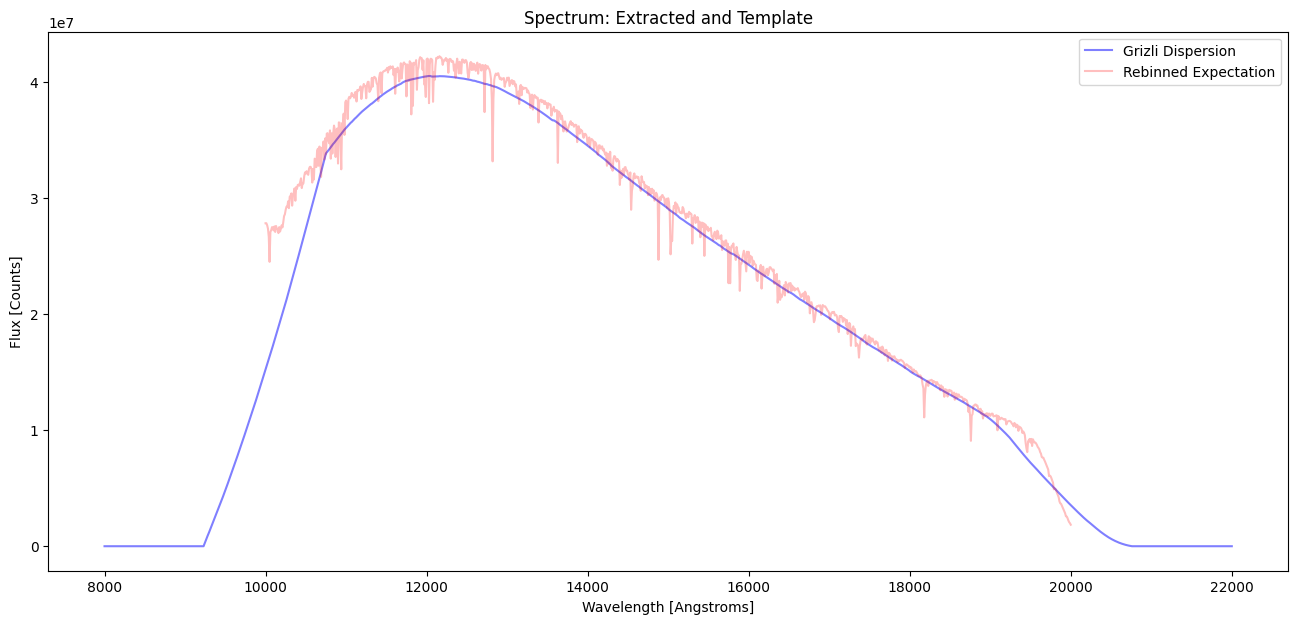

In [11]:
cutout = np.flip(upright[2144-501-300: 2144+500+100, :])
cutout_wave = np.linspace(10000-2000, 20000+2000, len(cutout))

counts = []
for ii in range(cutout.shape[0]):
    counts.append(cutout[ii,:].sum())

expected_values = star_spec.flux * interpolated_sens
binned_expectation = scipy.stats.binned_statistic(star_spec.wave, expected_values, statistic="sum", bins=1001)[0]
wave = np.linspace(10000, 20000, 1001)

plt.plot(cutout_wave, counts, c='b', alpha=0.5, label="Grizli Dispersion")
plt.plot(wave, binned_expectation, c='r', alpha=0.25, label="Rebinned Expectation")

plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [Counts]")
plt.title("Spectrum: Extracted and Template")
plt.legend()

# Cross/Plus
# Cross/Plus
# Cross/Plus

Text(0.5, 1.0, 'Segmentation Map')

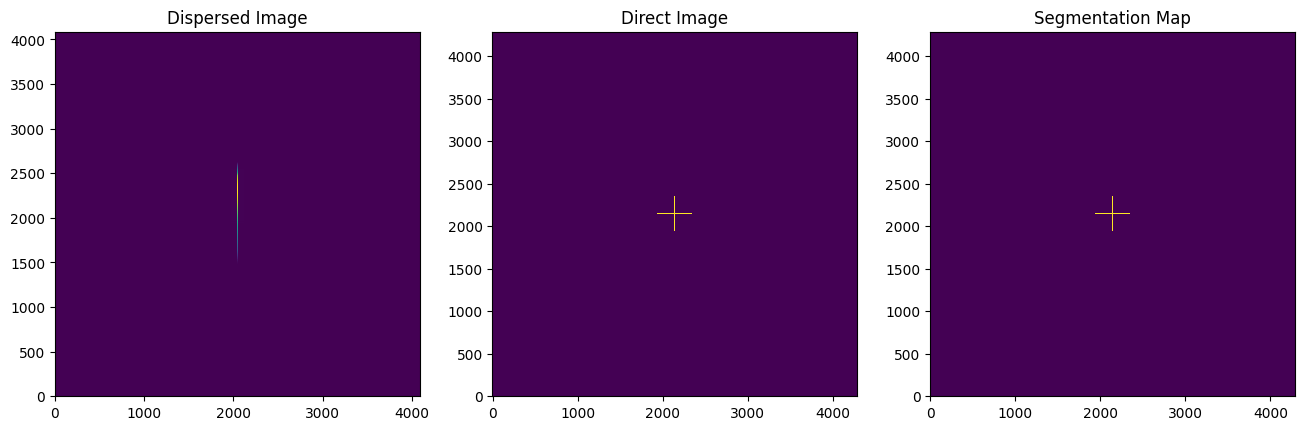

In [12]:
dir = np.zeros((4288,4288), dtype="float32")

dir[2144, 2144-200:2144+200] = 1.
dir[2144-200:2144+200, 2144] = 1.

roman.direct.data["SCI"] = roman.seg = dir

model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

upright = np.rot90(model[pad:-pad, pad:-pad])

ax1.imshow(upright)
ax1.set_title("Dispersed Image")

ax2.imshow(roman.direct.data["SCI"])
ax2.set_title("Direct Image")

ax3.imshow(roman.seg)
ax3.set_title("Segmentation Map")

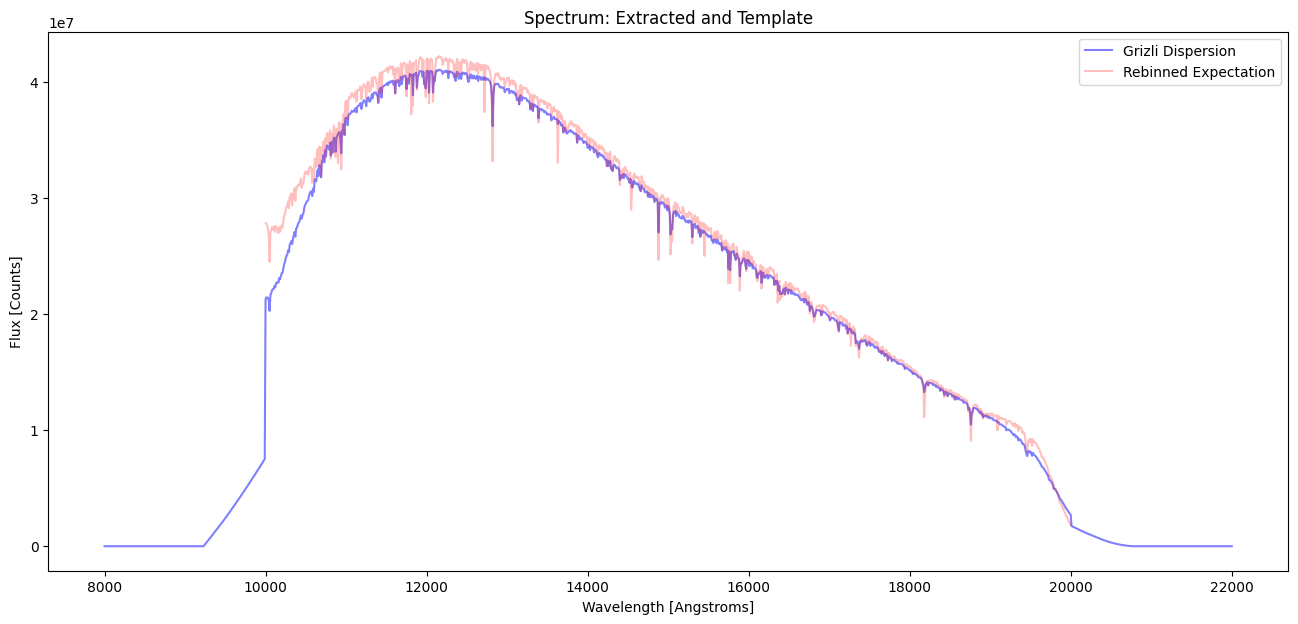

In [13]:
cutout = np.flip(upright[2144-501-300: 2144+500+100, :])
cutout_wave = np.linspace(10000-2000, 20000+2000, len(cutout))

counts = []
for ii in range(cutout.shape[0]):
    counts.append(cutout[ii,:].sum())

expected_values = star_spec.flux * interpolated_sens
binned_expectation = scipy.stats.binned_statistic(star_spec.wave, expected_values, statistic="sum", bins=1001)[0]
wave = np.linspace(10000, 20000, 1001)

plt.plot(cutout_wave, counts, c='b', alpha=0.5, label="Grizli Dispersion")
plt.plot(wave, binned_expectation, c='r', alpha=0.25, label="Rebinned Expectation")

plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [Counts]")
plt.title("Spectrum: Extracted and Template")
plt.legend()

# Square
# Square
# Square

Text(0.5, 1.0, 'Segmentation Map')

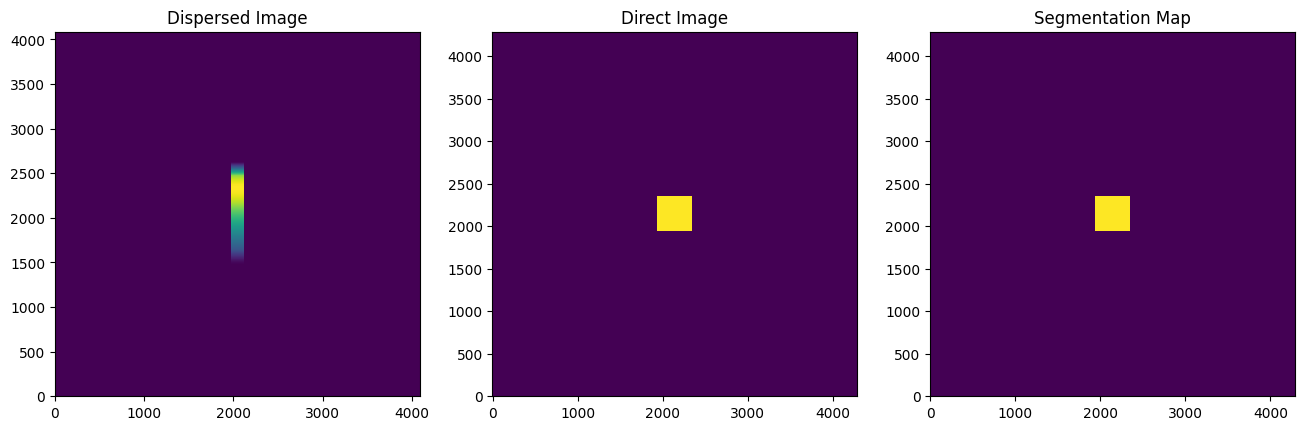

In [14]:
dir = np.zeros((4288,4288), dtype="float32")

dir[2144-200:2144+200, 2144-200:2144+200] = 1.

roman.direct.data["SCI"] = roman.seg = dir

model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

upright = np.rot90(model[pad:-pad, pad:-pad])

ax1.imshow(upright)
ax1.set_title("Dispersed Image")

ax2.imshow(roman.direct.data["SCI"])
ax2.set_title("Direct Image")

ax3.imshow(roman.seg)
ax3.set_title("Segmentation Map")

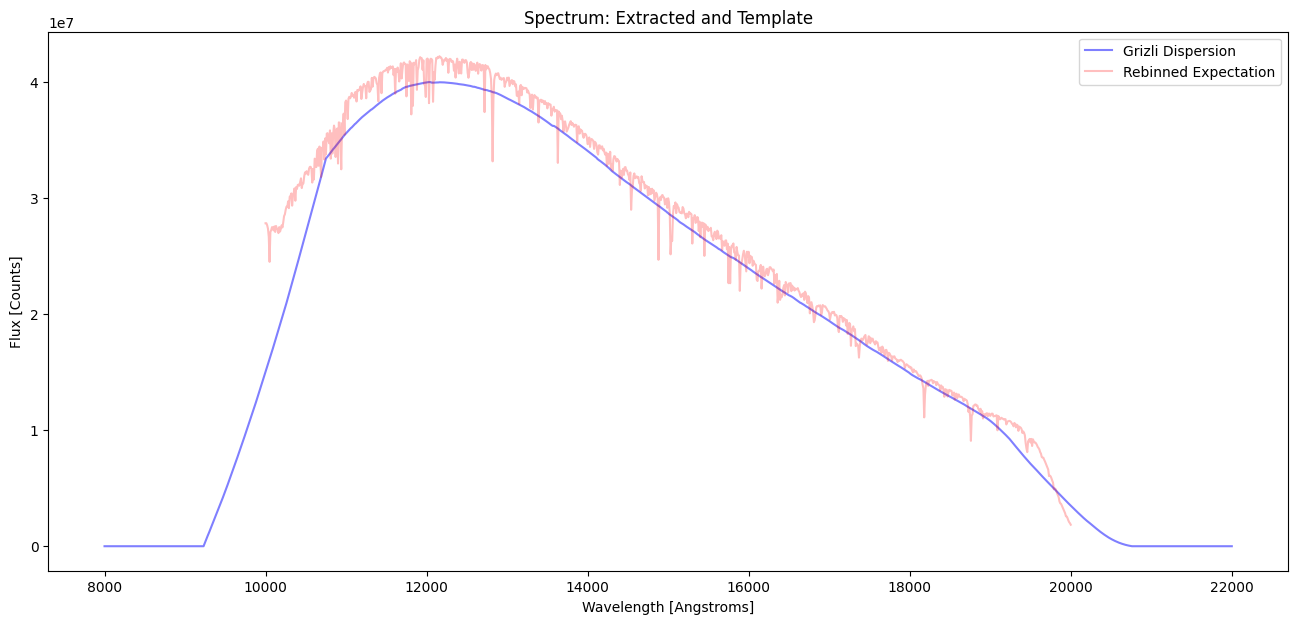

In [15]:
cutout = np.flip(upright[2144-501-300: 2144+500+100, :])
cutout_wave = np.linspace(10000-2000, 20000+2000, len(cutout))

counts = []
for ii in range(cutout.shape[0]):
    counts.append(cutout[ii,:].sum())

expected_values = star_spec.flux * interpolated_sens
binned_expectation = scipy.stats.binned_statistic(star_spec.wave, expected_values, statistic="sum", bins=1001)[0]
wave = np.linspace(10000, 20000, 1001)

plt.plot(cutout_wave, counts, c='b', alpha=0.5, label="Grizli Dispersion")
plt.plot(wave, binned_expectation, c='r', alpha=0.25, label="Rebinned Expectation")

plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [Counts]")
plt.title("Spectrum: Extracted and Template")
plt.legend()

# 2D Gaussian
# 2D Gaussian
# 2D Gaussian

Text(0.5, 1.0, 'Segmentation Map')

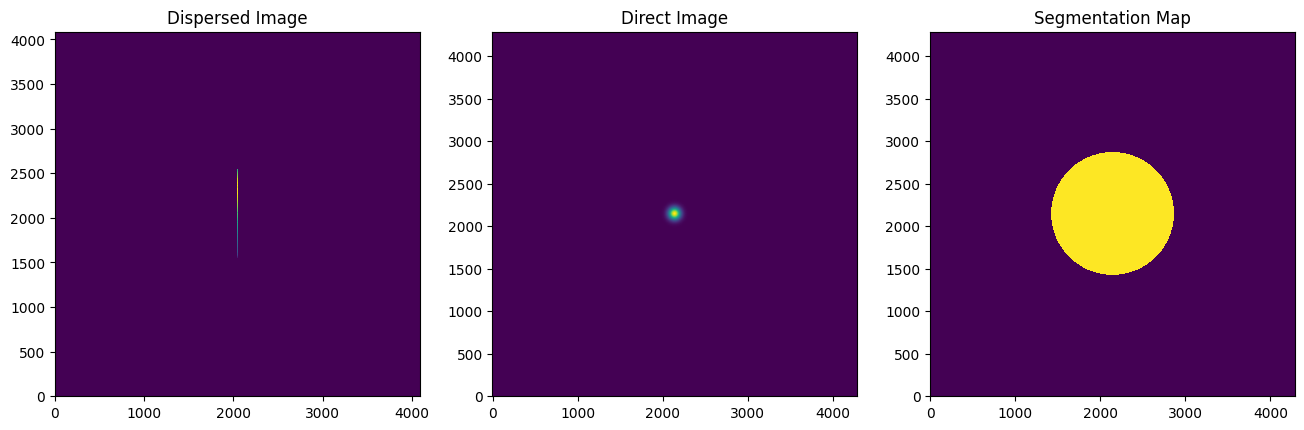

In [16]:
seg = np.zeros((4288,4288), dtype="float32")


args = {"amplitude": 1, "x_stddev": 1, "y_stddev": 1, "x_mean": 2144, "y_mean": 2144, "theta": 0}

roman.direct.data["SCI"] = np.fromfunction(lambda i,j: gauss.evaluate(i,j, **args), shape=(4288, 4288), dtype="float32")
roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

args["x_stddev"] = 5
args["y_stddev"] = 5

roman.direct.data["SCI"] = np.fromfunction(lambda i,j: gauss.evaluate(i,j, **args), shape=(4288, 4288), dtype="float32")
roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

model_2 = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

args["x_stddev"] = 50
args["y_stddev"] = 50

roman.direct.data["SCI"] = np.fromfunction(lambda i,j: gauss.evaluate(i,j, **args), shape=(4288, 4288), dtype="float32")
roman.seg = np.where(roman.direct.data["SCI"], 1, 0).astype("float32")

model_3 = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

upright = np.rot90(model[pad:-pad, pad:-pad])
upright_2 = np.rot90(model_2[pad:-pad, pad:-pad])
upright_3 = np.rot90(model_3[pad:-pad, pad:-pad])

ax1.imshow(upright)
ax1.set_title("Dispersed Image")

ax2.imshow(roman.direct.data["SCI"])
ax2.set_title("Direct Image")

ax3.imshow(roman.seg)
ax3.set_title("Segmentation Map")

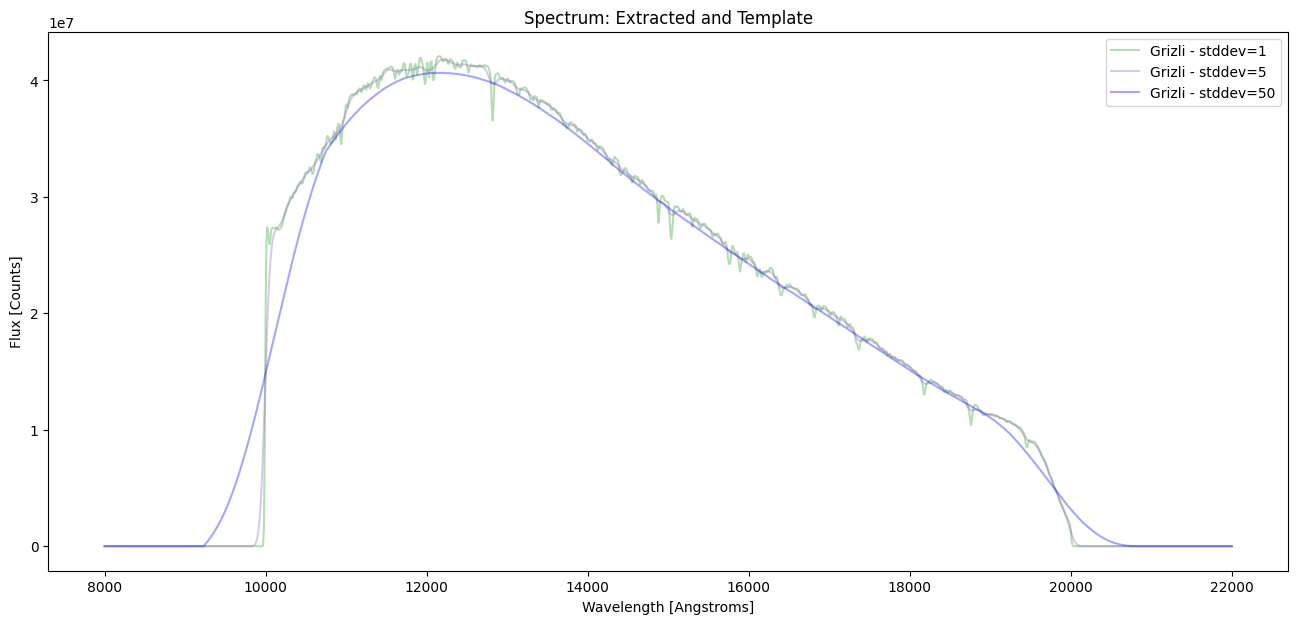

In [25]:
cutout = np.flip(upright[2144-501-300: 2144+500+100, :])
cutout_wave = np.linspace(10000-2000, 20000+2000, len(cutout))

counts = []
for ii in range(cutout.shape[0]):
    counts.append(cutout[ii,:].sum())

cutout_2 = np.flip(upright_2[2144-501-300: 2144+500+100, :])

counts_2 = []
for ii in range(cutout_2.shape[0]):
    counts_2.append(cutout_2[ii,:].sum())

cutout_3 = np.flip(upright_3[2144-501-300: 2144+500+100, :])

counts_3 = []
for ii in range(cutout_3.shape[0]):
    counts_3.append(cutout_3[ii,:].sum())



expected_values = star_spec.flux * interpolated_sens
binned_expectation = scipy.stats.binned_statistic(star_spec.wave, expected_values, statistic="sum", bins=1001)[0]
wave = np.linspace(10000, 20000, 1001)

plt.plot(cutout_wave, counts, c='tab:green', alpha=0.35, label="Grizli - stddev=1")
plt.plot(cutout_wave, counts_2, c='tab:purple', alpha=0.35, label="Grizli - stddev=5")
plt.plot(cutout_wave, counts_3, c='b', alpha=0.35, label="Grizli - stddev=50")
# plt.plot(wave, binned_expectation, c='r', alpha=0.35, label="Rebinned Expectation")

plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [Counts]")
plt.title("Spectrum: Extracted and Template")
plt.legend()